In [127]:
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import numpy as np
from datetime import date
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_theme()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import plotly.express as px
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller 

from adtk.detector import SeasonalAD
from adtk.visualization import plot


In [128]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [129]:
data=pd.read_csv("data.csv")

In [130]:
def snscount(att,title, rot=0,font=15):
    
    '''
    count plots
    '''
    sns.countplot(att)
    plt.title(title,loc="center")
    plt.xticks(rotation=rot)
    plt.xticks(fontsize=font)
    plt.show()
    
    
def expsmooth(alpha, back,i):
    '''
    grid search for parameters needed for filling missing values
    '''
    actual=dfdaily.Value[i]
    prev=[dfdaily.Value[i-7*(j+1)] for j in range(back)]
    prev=[prev[j]*alpha for j in range(back-1)]+[prev[-1]]
    
    pred=sum([prev[i]*(1-alpha)**i for i in range(back)])
    
    error=(pred-actual)/actual
    return error

def fillval(alpha, back,i):
    '''
    fitting missing values
    '''
    actual=dfdaily.Value[i]
    prev=[dfdaily.Value[i-7*(j+1)] for j in range(back)]
    prev=[prev[j]*alpha for j in range(back-1)]+[prev[-1]]
    
    pred=sum([prev[i]*(1-alpha)**i for i in range(back)])

    return pred          

## EDA

In [131]:
## changing column name and converting date to datetime format
data=data.rename(columns={"MeasurementTimeUtc":"dateTime"})
data.dateTime=pd.to_datetime(data.dateTime)
first=data.dateTime.min()
last=data.dateTime.max()
print(f"Data is given for every 30 minutes in the date range: {first} to {last}")


Data is given for every 30 minutes in the date range: 2016-03-01 00:00:00 to 2018-06-30 23:30:00


In [132]:
data.head()

,dateTime,Value
0,2016-03-01 00:00:00,0
1,2016-03-01 00:30:00,0
2,2016-03-01 01:00:00,0
3,2016-03-01 01:30:00,0
4,2016-03-01 02:00:00,0


In [133]:
data.isnull().sum()

dateTime    0
Value       0
dtype: int64

No null  values



#### Checking missing dates:

In [134]:
idx=pd.date_range(start=first,end=last,freq="30min")
data1=data.set_index(pd.DatetimeIndex(data['dateTime'])).drop(columns={"dateTime"})
data1.Value=data1.Value.astype("int")
data1=data1.reindex(idx,fill_value=-1)
data1=data1.reset_index().rename(columns={"index":"dateTime"})

We are filling null values as -1. Reasons:

    1. keeping it Null makes it computationally difficult eg, making the dtype float instead of integer
    
    2. Range of the actual count is [0, inf). -1 will not impact the data

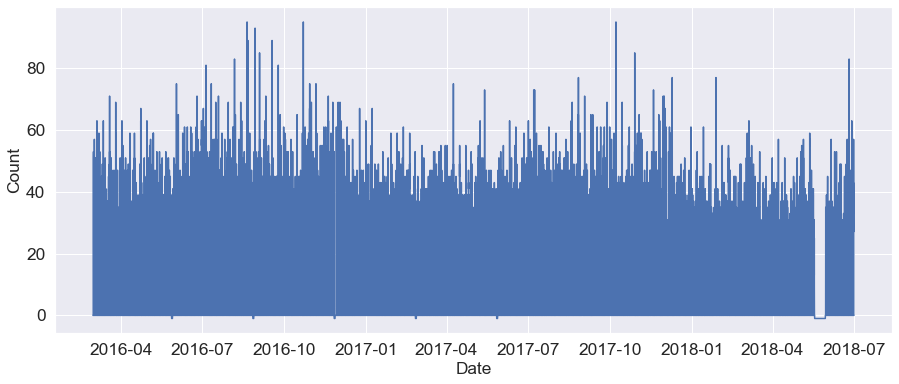

In [135]:
plt.plot(data1.dateTime,data1.Value)
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

In [136]:
data1[data1.Value==0].count()/len(data1)

dateTime    0.640967
Value       0.640967
dtype: float64

In [137]:
data1[data1.Value==-1].dateTime.dt.date.drop_duplicates()

4222     2016-05-27
4224     2016-05-28
8590     2016-08-26
8592     2016-08-27
12960    2016-11-26
17328    2017-02-25
21694    2017-05-26
21696    2017-05-27
38782    2018-05-17
38784    2018-05-18
38832    2018-05-19
38880    2018-05-20
38928    2018-05-21
38976    2018-05-22
39024    2018-05-23
39072    2018-05-24
39120    2018-05-25
39168    2018-05-26
39216    2018-05-27
39264    2018-05-28
39312    2018-05-29
Name: dateTime, dtype: object

In [138]:
#data1=data
data1["day"]=data1.dateTime.dt.day
data1["month"]=data1.dateTime.dt.month
data1["year"]=data1.dateTime.dt.year
data1["time"]=data1.dateTime.dt.strftime("%H:%M")
data1["date"]=data1.dateTime.dt.date
data1["whichday"]=data1.dateTime.dt.strftime('%A')

In [139]:
data1.head()

,dateTime,Value,day,month,year,time,date,whichday
0,2016-03-01 00:00:00,0,1,3,2016,00:00,2016-03-01,Tuesday
1,2016-03-01 00:30:00,0,1,3,2016,00:30,2016-03-01,Tuesday
2,2016-03-01 01:00:00,0,1,3,2016,01:00,2016-03-01,Tuesday
3,2016-03-01 01:30:00,0,1,3,2016,01:30,2016-03-01,Tuesday
4,2016-03-01 02:00:00,0,1,3,2016,02:00,2016-03-01,Tuesday


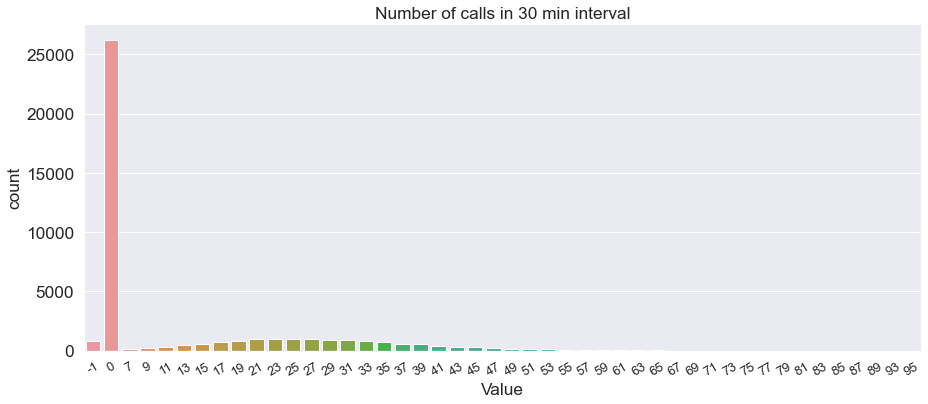

In [140]:
snscount(data1.Value,"Number of calls in 30 min interval",30,13)

#### A lot of zero values. Let us explore the zeroes first

In [141]:
datazero=data1[data1.Value==0]

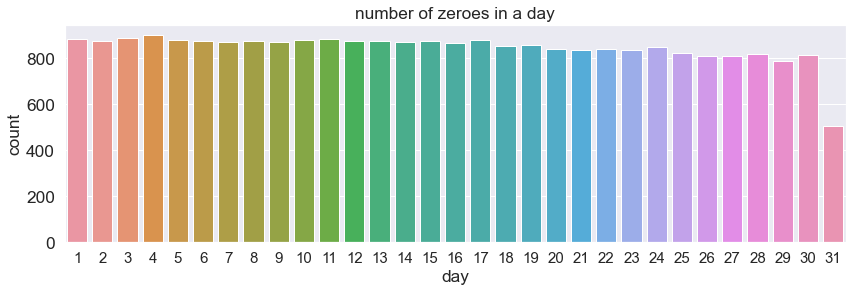

In [142]:
plt.figure(figsize=(14,4))
snscount(datazero.day,"number of zeroes in a day")

Since 31 does not occur in every month

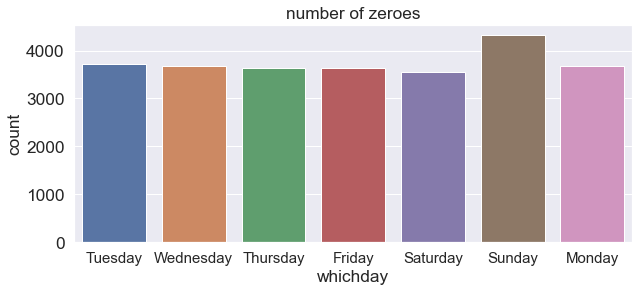

In [143]:
plt.figure(figsize=(10,4))
snscount(datazero["whichday"],"number of zeroes")

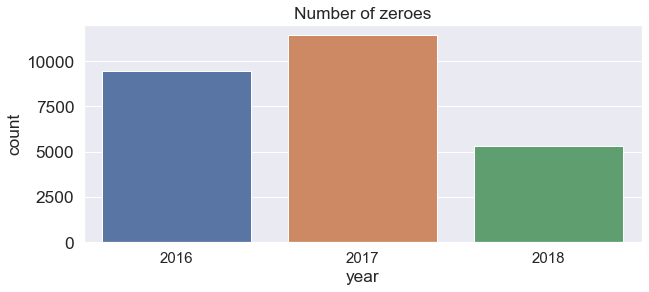

In [144]:
plt.figure(figsize=(10,4))
snscount(datazero.year,"Number of zeroes")

Discrepancy year wise is because of the data available

In [145]:
print(datazero.groupby("year").count()["Value"]/data1.groupby("year").count()["Value"])


year
2016    0.644404
2017    0.652568
2018    0.611763
Name: Value, dtype: float64


Not much difference 

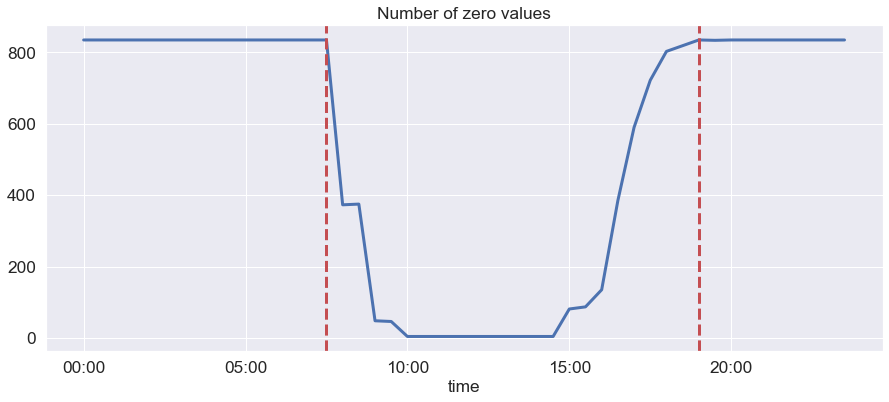

In [146]:
datazero.groupby("time").count()["Value"].plot(linewidth=3)
plt.title("Number of zero values")
plt.axvline(15, 0, 2,c="r",linewidth=3,linestyle="dashed")
plt.axvline(38, 0, 1,c="r",linewidth=3,linestyle="dashed")
#plt.xticks(datazero.time.unique())
plt.show()

It indicates the working hours 

<AxesSubplot:xlabel='time'>

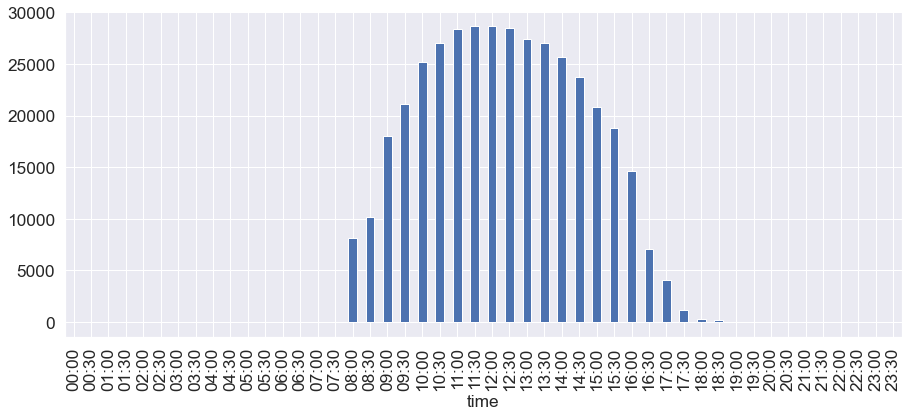

In [147]:
data1.groupby("time").sum()["Value"].plot(kind="bar")

Working hours: 8:00 am to 7:00 pm.

We remove the data for closing hours

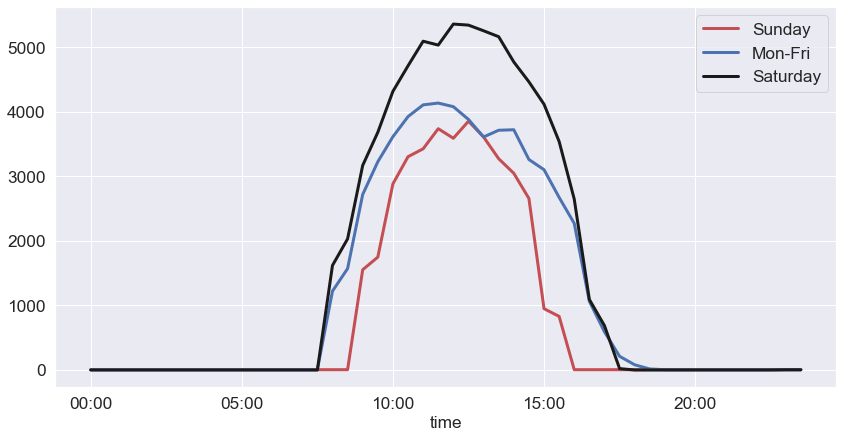

In [148]:
plt.figure(figsize=(14,7))
data1[data1.whichday=="Sunday"].groupby("time")["Value"].sum().plot(label="Sunday",color="r",linewidth=3)

data1[data1.whichday=="Monday"].groupby("time")["Value"].sum().plot(label="Mon-Fri",color="b",linewidth=3)
data1[data1.whichday=="Saturday"].groupby("time")["Value"].sum().plot(label="Saturday",color="k",linewidth=3)
plt.legend()
plt.show()

Diffrerent timings for Mon-Fri, Saturday, Sunday. 

* Mon-Fri: 8am-7pm: 11 hours
* saturday: 8am - 6pm: 10 hours
* Sunday:9am -4pm: 7 hours

It calls for readjustment as values for Saturday are generally much higher and values for sunday are much lower. However, normal distribution indicates that the tail effect readjustment will not affect too much. We take this weekly seasonality as the base for our model.

In [149]:
cm = plt.get_cmap("Accent")
j=0

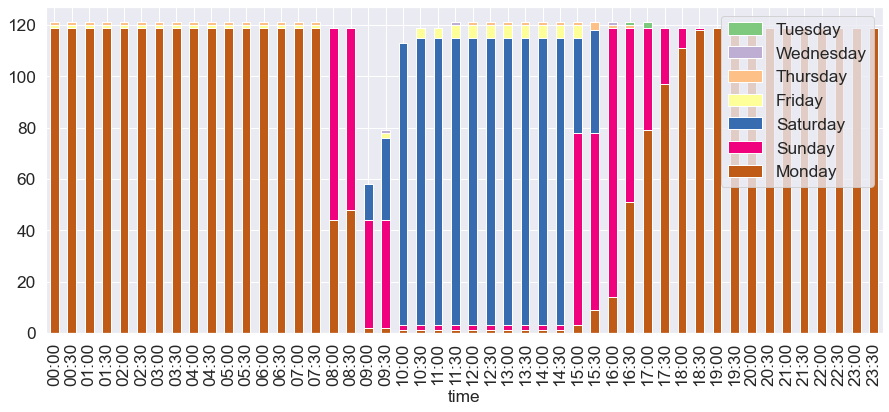

In [150]:
for i in datazero.whichday.unique():
    datazero[datazero.whichday==i].groupby("time")["Value"].count().plot(label=i,kind="bar",color=cm(j/7))
    j+=1
    plt.legend(loc='best')

In [151]:
data1=data1[(data1.dateTime.dt.time>=datetime.time(8,0,0)) &(data1.dateTime.dt.time<=datetime.time(18,30,0))].reset_index(drop=True)



In [152]:
print(f"Number of entries in a day: {data1.groupby('date').count()['Value'][0]}")

Number of entries in a day: 22


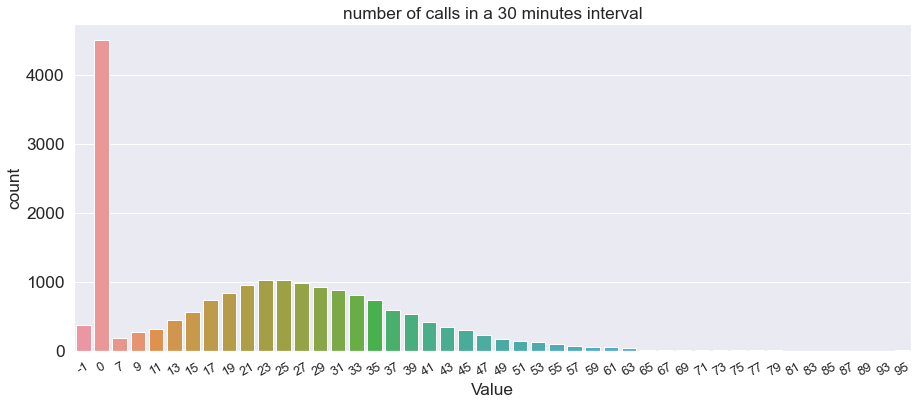

In [153]:
snscount(data1.Value,"number of calls in a 30 minutes interval",30,13)


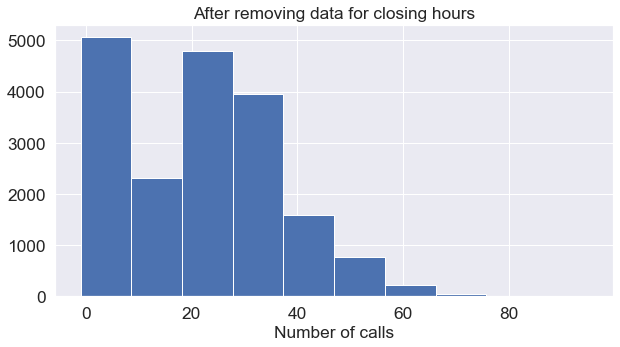

In [154]:
plt.figure(figsize=(10,5))
plt.xlabel("Number of calls")
plt.title("After removing data for closing hours",loc="center")
data1.Value.hist()
plt.show()

### Looking into null values

In [155]:
adfuller(data1.Value)

(-11.890474805113175,
 5.884917701691294e-22,
 45,
 18698,
 {'1%': -3.430699780616658,
  '5%': -2.8616945901463184,
  '10%': -2.566852284213818},
 132814.7186352518)

In [156]:
datanull=data1[data1.Value==-1]

In [157]:
datanull.count()

dateTime    374
Value       374
day         374
month       374
year        374
time        374
date        374
whichday    374
dtype: int64

In [158]:
datanull.date.unique()

array([datetime.date(2016, 5, 28), datetime.date(2016, 8, 27),
       datetime.date(2016, 11, 26), datetime.date(2017, 2, 25),
       datetime.date(2017, 5, 27), datetime.date(2018, 5, 18),
       datetime.date(2018, 5, 19), datetime.date(2018, 5, 20),
       datetime.date(2018, 5, 21), datetime.date(2018, 5, 22),
       datetime.date(2018, 5, 23), datetime.date(2018, 5, 24),
       datetime.date(2018, 5, 25), datetime.date(2018, 5, 26),
       datetime.date(2018, 5, 27), datetime.date(2018, 5, 28),
       datetime.date(2018, 5, 29)], dtype=object)

In [159]:
# for i in cols:
#     sns.countplot(datanull[i])
#     if i=="time":
#         plt.xticks(rotation=30)
#         plt.xticks(fontsize=13)
#     plt.show()

In [160]:
df1=data1.set_index("dateTime")
fig=px.line(df1.Value,title="count")

fig.update_xaxes( rangeslider_visible=True, rangeselector=dict())

Converting into day values

In [247]:
dfdaily=data1[["Value","date"]].groupby("date").sum()
dfdaily.head()

,Value
date,
2016-03-01,579
2016-03-02,476
2016-03-03,510
2016-03-04,544
2016-03-05,634


In [233]:

fig=px.line(dfdaily.Value,title="count")
fig.update_xaxes( rangeslider_visible=True, rangeselector=dict())

In [248]:
dfdaily["ma7"]=dfdaily.Value.rolling(7).mean()
dfdaily["ma30"]=dfdaily.Value.rolling(30).mean()

Text(0.5, 0, 'Date')

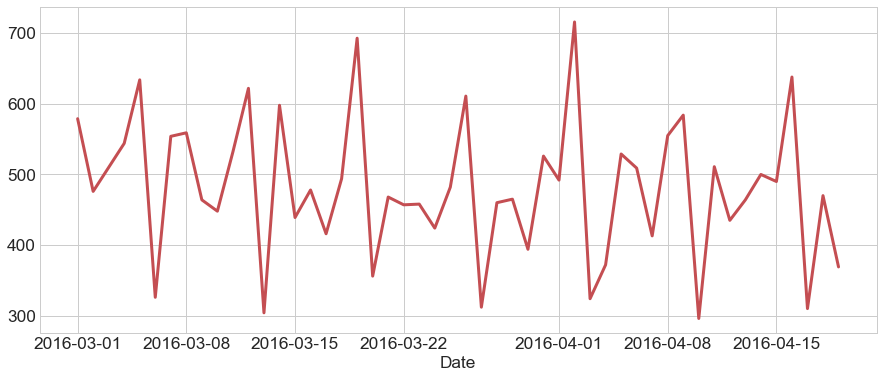

In [235]:
plt.plot(dfdaily.Value[0:50],linewidth=3,color='r')
plt.xlabel("Date")

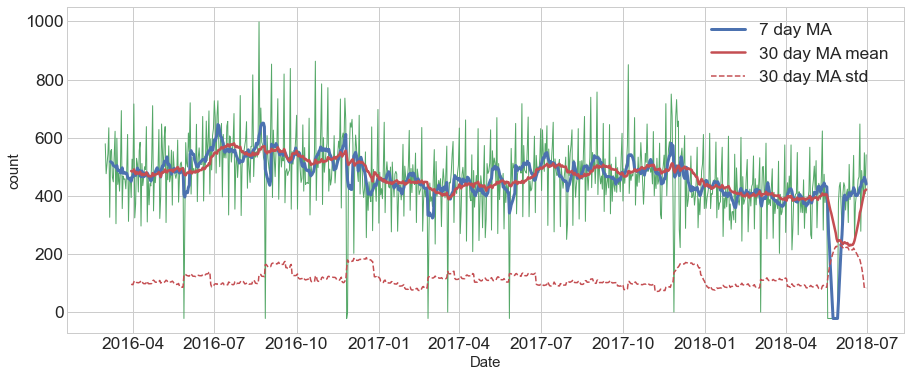

In [249]:
plt.plot(dfdaily.Value,linewidth=1,color='g')

plt.plot(dfdaily.ma7,label="7 day MA",color='b',linewidth=3)
plt.plot(dfdaily.ma30,label="30 day MA mean",color='r',linewidth=2.5)
plt.plot(dfdaily.Value.rolling(30).std(),"r--",label="30 day MA std")
plt.legend(loc='best')
plt.xlabel("Date",fontsize=15)
plt.ylabel("count",fontsize=15)
plt.show()

In [250]:
dfdaily=dfdaily.reset_index()

In [251]:
dfdaily=dfdaily.set_index(pd.to_datetime(dfdaily.date),drop=True)

In [252]:
dfdaily[dfdaily.Value==-22].date.count()

17

### Looking for anomalies

number of anomalies plus missing values: False    827
True      25
Name: Value, dtype: int64


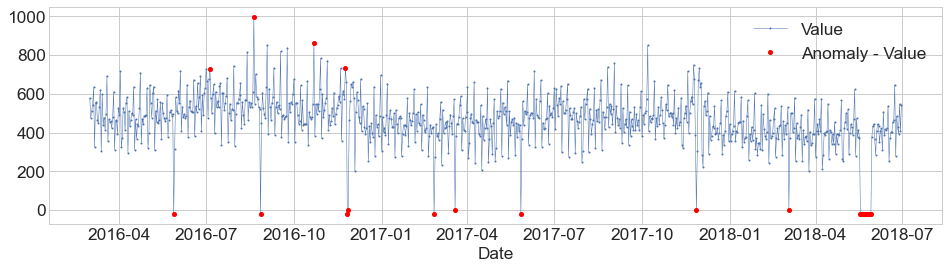

In [253]:
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(dfdaily[["Value"]])
print(f"number of anomalies plus missing values: {anomalies.Value.value_counts()}")

plot(dfdaily.Value, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

plt.xlabel("Date")
plt.show()

There are 25-17=8 anomalies. It includes 17 missing values as well which have value=-22.

#### Fixing anomalies and missing values

In [240]:
randi=[200,400,600]
alpha=[0.2,0.4,0.6,0.8]
back=[5,10,20,30]

In [241]:
errlist=[]
for i in alpha:
    for k in back:
        err=0
        for j in randi:
            err+=expsmooth(i,k,j)
            errlist.append([i,k,err])

In [242]:
pd.DataFrame(errlist,columns=["alpha","lags","err"]).sort_values("err",ascending=False).iloc[1]

alpha     0.800000
lags     30.000000
err      -0.107909
Name: 45, dtype: float64

In [254]:
anomaly=anomalies.rename(columns={"Value":"anomaly"})

In [255]:
dfdaily=dfdaily.join(anomaly)

In [290]:
dfdaily.anomaly[0]

False

In [ ]:
for i in range(if dfdaily.anomaly.bool()==True:  
        print()

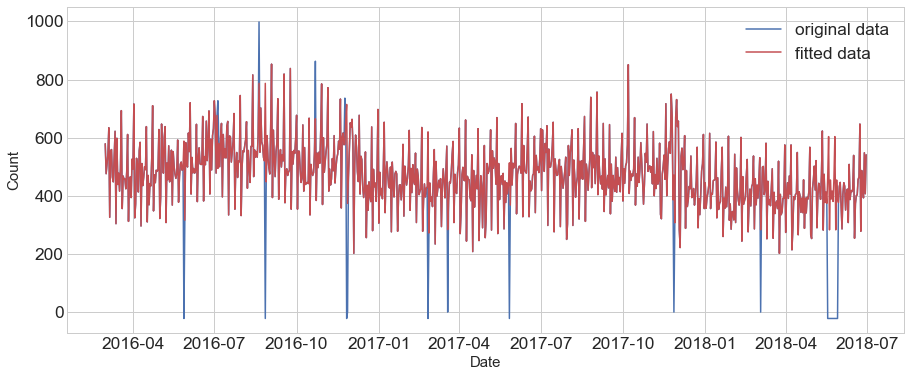

In [291]:
alpha=0.8
#dfdaily=data1[["Value","date"]].groupby("date").sum()
#plt.figure(figsize=(28,18))
plt.plot(dfdaily.Value,label="original data")
for i in range(len(dfdaily)):
    if dfdaily.anomaly[i]==True:  
        val=fillval(alpha, 30,i)
        dfdaily.Value.iloc[i]=val
plt.xlabel("Date",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.plot(dfdaily.Value,'r',label="fitted data")
plt.legend(loc="best")
plt.show()

### decomposition

In [292]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [293]:
decomp=seasonal_decompose(dfdaily.Value, model='additive', period = 7)

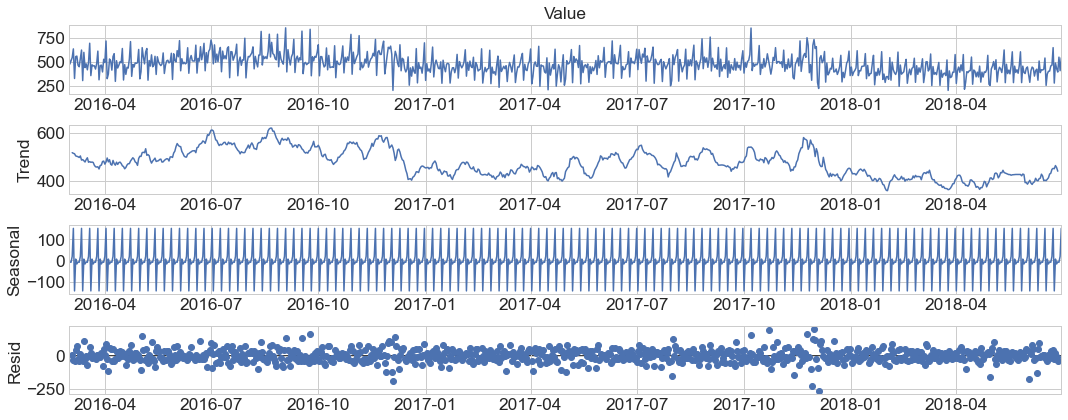

In [294]:
fig=decomp.plot()

<AxesSubplot:xlabel='date'>

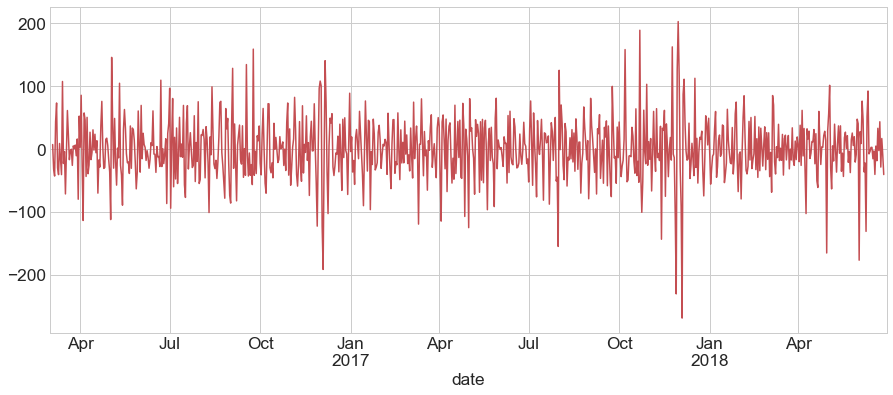

In [295]:
decomp.resid.plot(c='r')

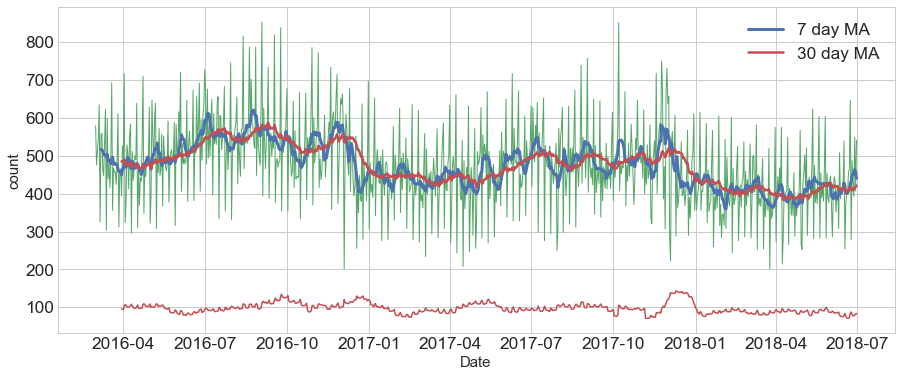

In [296]:
dfdaily["ma7"]=dfdaily.Value.rolling(7).mean()
dfdaily["ma30"]=dfdaily.Value.rolling(30).mean()
plt.plot(dfdaily.Value,linewidth=1,color='g')

plt.plot(dfdaily.ma7,label="7 day MA",color='b',linewidth=3)
plt.plot(dfdaily.ma30,label="30 day MA",color='r',linewidth=2.5)
plt.plot(dfdaily.Value.rolling(30).std(),color="r")
plt.legend(loc='best')
plt.xlabel("Date",fontsize=15)
plt.ylabel("count",fontsize=15)
plt.show()

In [41]:
dfdaily=dfdaily[["Value"]]

In [42]:
dfdaily.index=pd.to_datetime(dfdaily.index)

In [43]:
dfdaily["whichday"]=dfdaily.index.strftime("%A")

In [44]:
days=dfdaily.whichday.unique()

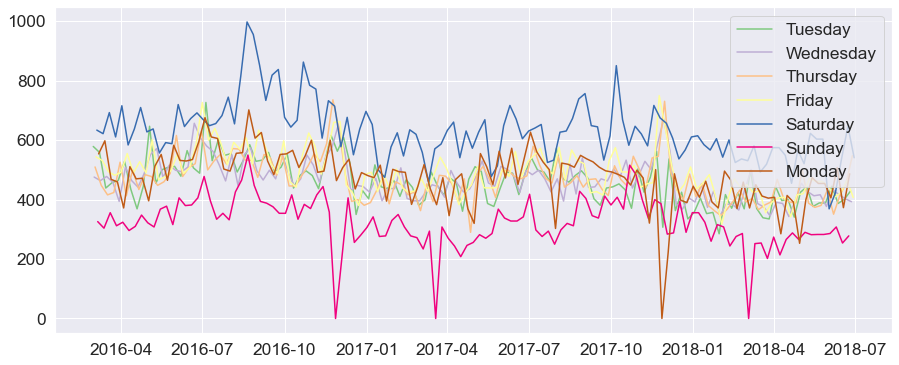

In [45]:
fig, ax = plt.subplots()
cm = plt.get_cmap("Accent")
for (i,p) in enumerate(days):
    col=cm(i/len(days))
    temp=dfdaily[dfdaily.whichday==p]
    ax.plot(temp.Value,color=col,label=p)
    plt.legend(loc='best')

In [297]:
dfdaily[["Value"]].to_csv("dfdaily.csv")